In [1]:

%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as sig

os.chdir(os.path.dirname(os.getcwd()))
import spatial_metrics.helper_functions as hf
import spatial_metrics.cell_model_base as cs_model
import spatial_metrics.detect_peaks as dp
import spatial_metrics.spatial_metrics_spikes_base as pl_spk
import spatial_metrics.spatial_prediction_spikes_base as sp_spk


In [2]:
os.chdir(os.path.dirname(os.getcwd()))


In [23]:
# Define field parameters
num_of_fields = 3  # Number of fields (place fields in this context)

# Coordinates and sizes of the fields
field1_center = (25, 20)  # Center coordinates of field 1
field2_center = (10, 5)   # Center coordinates of field 2
field3_center = (5, 30)   # Center coordinates of field 3
field1_size = 4           # Size of field 1
field2_size = 2           # Size of field 2
field3_size = 2           # Size of field 3

# Cell simulation parameters
sampling_rate = 30.0  # Sampling rate in points/frames per second
duration = 500        # Duration of the simulation in seconds
environment_edges = [[0, 50], [0, 30]]  # Environment boundaries in cm [[x_min,x_max],[y_min,y_max]]

rate = 10             # Firing rate of the neuron in Hz
smooth_time = 0.1     # Time window for smoothing in seconds
rho1 = 0.02           # Parameter for random walk model (e.g., angular velocity component)
sigma = 1             # Standard deviation of random walk noise
mu_e = 0.0            # Mean of random walk noise

# Generate random walk in the environment
x_coordinates, y_coordinates, speed, speed_smoothed, time_vector = cs_model.generate_random_walk(
    input_srate=sampling_rate,            # Input sampling rate
    input_total_Time=duration,            # Total time for simulation
    heading_srate=10.,                    # Heading sampling rate
    speed_srate=5.,                       # Speed sampling rate
    rho1=rho1,                            # Parameter for random walk
    sigma=sigma,                          # Noise level
    mu_e=mu_e,                            # Mean of noise
    smooth_points=int(np.round(smooth_time * sampling_rate)),  # Points for smoothing
    environment_edges=environment_edges   # Boundaries of the environment
)
total_points = time_vector.shape[0]  # Total number of points in the simulation

# Generate Poisson spikes
spike_times = cs_model.generate_poisson_spikes(rate, duration)  # Generate spike times in seconds
spike_times_idx = (spike_times * sampling_rate).astype(int)     # Convert spike times to indices

# Modulate spikes based on place fields
modulated_spike_times_idx = []  # Initialize list for modulated spike times indices
for counter in range(num_of_fields):
    field_center = eval('field' + str(counter + 1) + '_center')  # Get center of the field
    field_size = eval('field' + str(counter + 1) + '_size')      # Get size of the field
    
    # Digitize spike times based on proximity to the field center
    modulated_spike_times_idx_aux = cs_model.digitize_spiketimes(
        x_coordinates, y_coordinates, spike_times_idx,
        x_center=field_center[0], y_center=field_center[1], s=field_size
    )
    modulated_spike_times_idx.append(modulated_spike_times_idx_aux)  # Append to list

# Combine all modulated spike times and ensure uniqueness
spike_times_idx = np.unique(np.concatenate(modulated_spike_times_idx))

# Plot spike events
plt.figure()
plt.eventplot(time_vector[spike_times_idx],color='black',lineoffsets=0,linelengths=2)
plt.ylim([-2,2])
plt.show()

# Plot spike events in the environment
plt.figure()
plt.plot(x_coordinates,y_coordinates,'k')
plt.plot(x_coordinates[spike_times_idx],y_coordinates[spike_times_idx],'r.')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


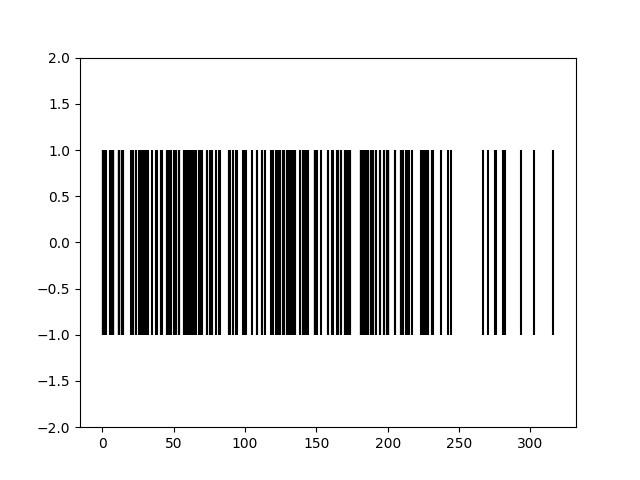

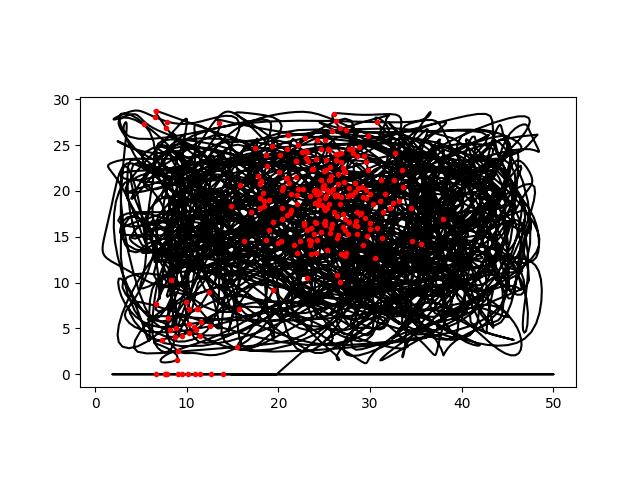

- Parameters for Filename Creation and Saving:
    These parameters assist in constructing a filename and saving the results. If you do not wish to save the results and prefer to work with the object directly, you can ignore these settings by setting the 'saving' flag to False.
    - 'saving_string': Prefix used for creating the filename to save the results.
    - 'animal_id': Identifier for the animal.
    - 'dataset': Name of the dataset.
    - 'day': Session or day of the experiment.
    - 'neuron': Identifier for the neuron.
    - 'trial': Identifier for the trial.
    - 'saving_path': Directory path where the results will be saved.
    - 'saving': Boolean flag indicating whether to save the results (True) or not (False).

- Parameters for Signal and Tracking:
    - 'sampling_rate': The rate at which the signal and tracking data are sampled.
    - 'environment_edges': Coordinates defining the boundaries of the environment.

- Inclusion Criteria for Analysis:
    - 'min_time_spent': Minimum time an animal must spend in each xy bin to be considered.
    - 'min_visits': Minimum number of visits required to each xy bin.
    - 'min_speed_threshold': Minimum speed threshold in coordinate units for the analysis.

- Information Parameters:
    - 'x_bin_size': Size of x bins in coordinate units used to calculate mutual information.
    - 'y_bin_size': Size of y bins in coordinate units used to calculate mutual information.

- Surrogate Analysis Parameters:
    - 'shift_time': Time shift window (in seconds) for creating surrogate distributions by randomly shifting the signal from -shift_time to +shift_time.
    - 'num_cores': Number of CPU cores to be used for the analysis. Set to -1 to utilize all available cores.
    - 'num_surrogates': Number of surrogate distributions to generate.

- Place Field Parameters:
    - 'smoothing_size': Size of the smoothing area in bins for plotting place fields.
    - 'percentile_threshold': Percentile threshold used to determine place field boundaries based on surrogate distributions.
    - 'min_num_of_bins': Minimum number of bins required to define a place field.

Note: Ensure that the variables time_vector, x_coordinates and y_coordinates are vectors of the same size. You may need to downsample or upsample your signal or xy tracking coordinates to match their dimensions.


# If you have pre-existing data, bypass the previous code cells and load the data directly
# This is useful if you want to avoid re-running the preceding setup and instead work with already available data


In [ ]:
# Load data
# - np.ndarray: time_vector, x_coordinates, y_coordinates (all with the same shape)
# - spike_times_idx: An array of indices representing spike events. 
#   The expression time_vector[spike_times_idx] should return the approximate spike times.


In [5]:
# Calculate the video sampling rate as the reciprocal of the average time difference between consecutive timestamps.
# This is an approximation for cameras with varying frame rates.
sampling_rate = 1 / np.nanmean(np.diff(time_vector))

signal_type = 'Spikes'  # Define the type of signal being analyzed

# Create a dictionary to hold input parameters for further processing
input_dict = dict()

# Construct the filename and other identifiers for saving the results
input_dict['saving_string'] = 'SpatialMetrics.' + signal_type  # Prefix for the filename
input_dict['animal_id'] = 'NeuronModel'  # Identifier for the animal or model
input_dict['dataset'] = 'Simulation'  # Name of the dataset
input_dict['day'] = 1  # Day or session number
input_dict['neuron'] = 1  # Neuron identifier
input_dict['trial'] = None  # Trial identifier (optional, can be None)
input_dict['saving_path'] = None  # Directory path for saving results (optional, can be None)
input_dict['saving'] = False  # Flag indicating whether to save the results (False means no saving)

# Set parameters related to the signal and environment
input_dict['sampling_rate'] = sampling_rate  # Sampling rate in points per second
input_dict['environment_edges'] = environment_edges  # Coordinates defining the edges of the environment (in cm)

# Set inclusion criteria for the analysis
input_dict['min_time_spent'] = 0  # Minimum time an animal must spend in each xy bin
input_dict['min_visits'] = 0  # Minimum number of visits required in each xy bin
input_dict['min_speed_threshold'] = 5  # Minimum speed threshold in coordinate units

# Set parameters for calculating mutual information
input_dict['x_bin_size'] = 1  # Size of x bins in coordinate units (cm)
input_dict['y_bin_size'] = 1  # Size of y bins in coordinate units (cm)

# Set parameters for surrogate analysis
input_dict['shift_time'] = 200  # Time shift window in seconds for creating surrogate distributions
input_dict['num_cores'] = -1  # Number of CPU cores to use (set to -1 to use all available cores)
input_dict['num_surrogates'] = 80  # Number of surrogate distributions to generate

# Set parameters for plotting place fields
input_dict['smoothing_size'] = 2  # Size of the smoothing area in bins for plotting place fields
input_dict['percentile_threshold'] = 99  # Percentile threshold for determining place field boundaries
input_dict['min_num_of_bins'] = 4  # Minimum number of bins required to define a place field

# Create a PlaceCell object with the specified parameters and run the main analysis
place_cell = pl_spk.PlaceCell(**input_dict)  # Instantiate the PlaceCell class with parameters
place_cell_output = place_cell.main(spike_times_idx, time_vector, x_coordinates, y_coordinates) 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s


File not saved


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.2s finished


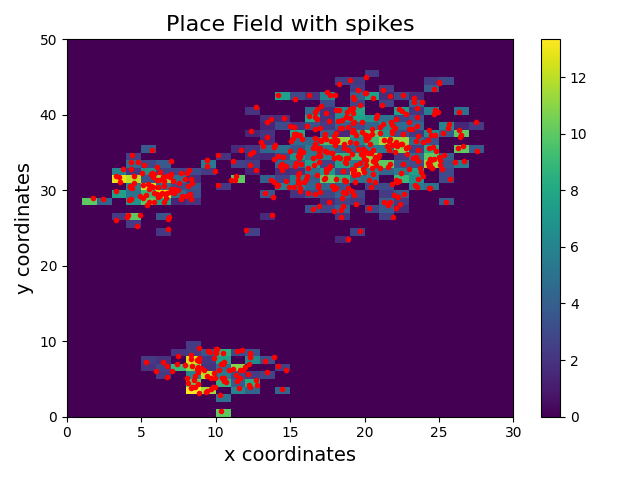

In [6]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field'],shading = 'auto',edgecolors=None)
# plt.pcolormesh(place_cell_output['x_grid'],place_cell_output['y_grid'],place_cell_output['place_field'],edgecolors='red')

plt.plot(place_cell_output['x_peaks_location'],place_cell_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6)
plt.colorbar()
plt.title('Place Field with spikes',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



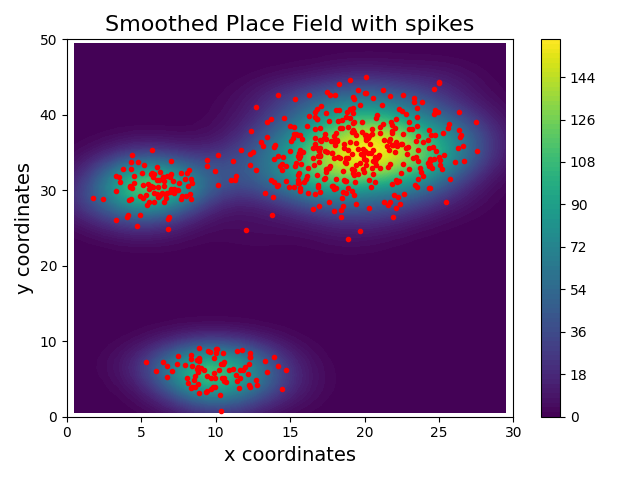

In [7]:

plt.figure()
plt.contourf(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'],100,cmap='viridis')
plt.plot(place_cell_output['x_peaks_location'],place_cell_output['y_peaks_location'],color = 'red',linestyle='',marker='.',markersize=6)
plt.colorbar()
plt.title('Smoothed Place Field with spikes',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
# plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()



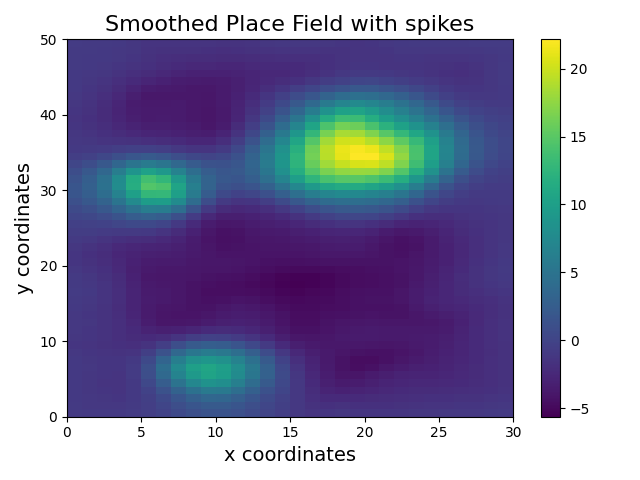

In [8]:

mean_place_field_shuffled = np.nanmean(place_cell_output['place_field_smoothed_shifted'],0)
std_place_field_shuffled = np.nanstd(place_cell_output['place_field_smoothed_shifted'],0)
place_field_smoothed = place_cell_output['place_field_smoothed'].copy()
place_field_smoothed_zscored = (place_field_smoothed - mean_place_field_shuffled)/std_place_field_shuffled

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_field_smoothed_zscored)
plt.colorbar()
plt.title('Smoothed Place Field with spikes',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()




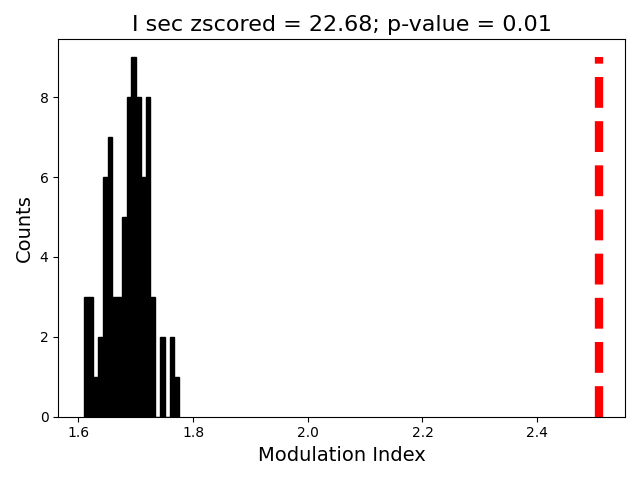

In [9]:
p_value = hf.calculate_p_value(place_cell_output['I_sec_original'], place_cell_output['I_sec_shifted'] )


counts,bins = np.histogram(place_cell_output['I_sec_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['I_sec_original'],place_cell_output['I_sec_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("I sec zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['I_sec_zscored'],p_value),fontsize=16)
plt.xlabel('Modulation Index',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


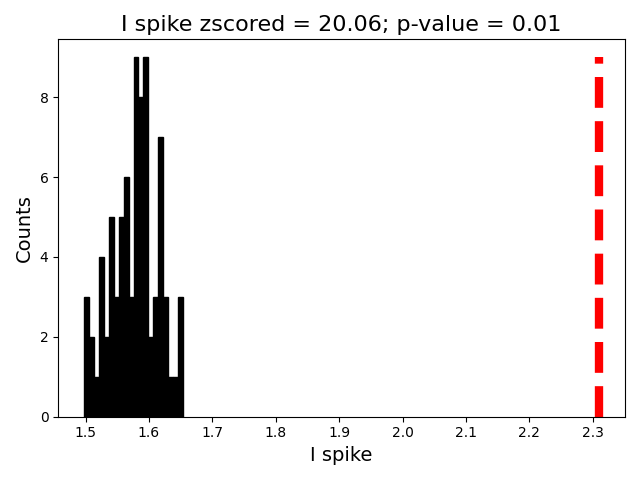

In [10]:
# p value is defined as the amount of shuffled mutual information values above the original one 
p_value = hf.calculate_p_value(place_cell_output['I_spk_original'], place_cell_output['I_spk_shifted'] )

counts,bins = np.histogram(place_cell_output['I_spk_shifted'],20)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([place_cell_output['I_spk_original'],place_cell_output['I_spk_original']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("I spike zscored = {0:.2f}; p-value = {1:.2f}".format(place_cell_output['I_spk_zscored'],p_value),fontsize=16)
plt.xlabel('I spike',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()


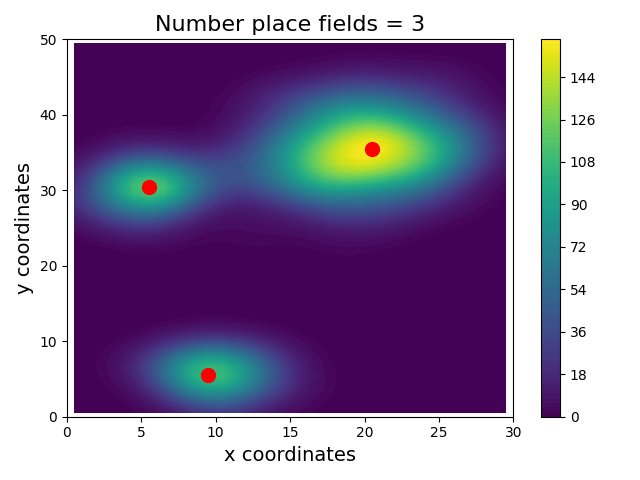

In [11]:
# place field identity and location

plt.figure()
plt.contourf(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_smoothed'],100)
plt.colorbar()
plt.plot(place_cell_output['x_center_bins'][place_cell_output['islands_x_max']],place_cell_output['y_center_bins'][place_cell_output['islands_y_max']],color='red',linestyle='',marker='.',markersize=20)
plt.title('Number place fields = {0}'.format(place_cell_output['num_of_islands']) ,fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


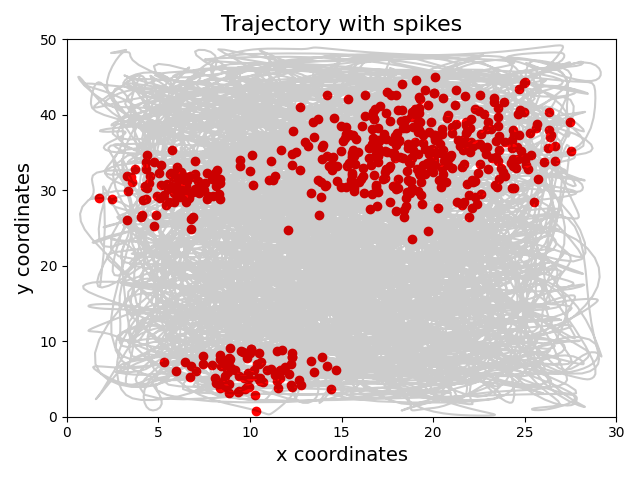

In [13]:

x_peaks_location = place_cell_output['x_peaks_location']
y_peaks_location = place_cell_output['y_peaks_location']

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',alpha=0.2)
plt.scatter(x_peaks_location,y_peaks_location,color='red')
plt.title('Trajectory with spikes',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


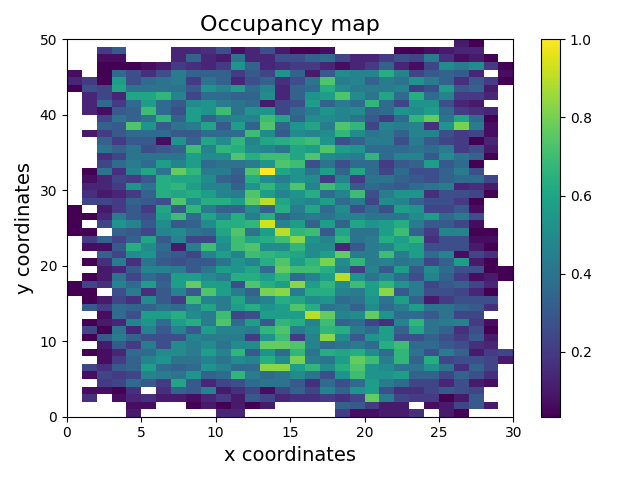

In [14]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['occupancy_map'])
plt.colorbar()
plt.title('Occupancy map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


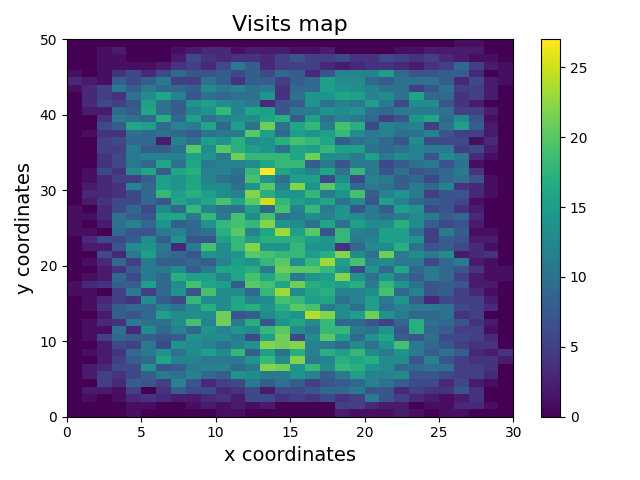

In [15]:

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['visits_map'])
plt.colorbar()
plt.title('Visits map',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()


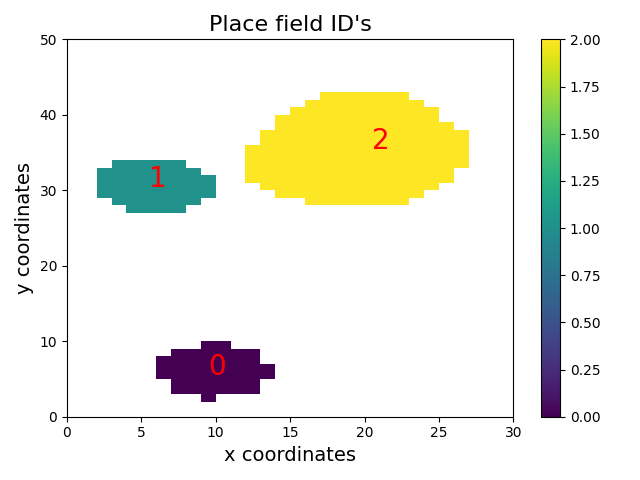

In [16]:
place_cells_x_center_coord = place_cell_output['x_center_bins'][place_cell_output['islands_x_max']]
place_cells_y_center_coord = place_cell_output['y_center_bins'][place_cell_output['islands_y_max']]

plt.figure()
plt.pcolormesh(place_cell_output['x_center_bins'],place_cell_output['y_center_bins'],place_cell_output['place_field_identity'])
plt.colorbar()


for counter,(x, y) in enumerate(zip(place_cells_x_center_coord, place_cells_y_center_coord)):
    plt.text(x, y, str(counter), color='red',fontsize=20)

plt.title("Place field ID's",fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.tight_layout()
plt.show()



In [17]:
# Place fields id's listed in place_cell_output['place_field_identity'] 
# can be used as indexes for place_cell_extension_absolute and place_cell_extension_relative

In [17]:
# Place field extension relative to the whole enviroment
place_cell_output['place_cell_extension_absolute']


array([0.02933333, 0.03066667, 0.118     ])

In [18]:
# Place field extension relative to enviroment occupancy
place_cell_output['place_cell_extension_relative']


array([0.03335861, 0.03487491, 0.13419257])